# Proyek Analisis Data: Air-quality-dataset
- **Nama:** Arya Setia Pratama
- **Email:** aryasetia30@gmail.com
- **ID Dicoding:** aryasetia30

## Menentukan Pertanyaan Bisnis

- Bagaimana tren kualitas udara (PM2.5 dan PM10) di berbagai lokasi dari tahun 2013 hingga 2017?
- Apa faktor meteorologi (seperti suhu, kelembapan, dan curah hujan) yang paling berpengaruh terhadap konsentrasi polutan (seperti PM2.5 dan NO2) di daerah tertentu?
- Apakah ada perbedaan signifikan dalam kualitas udara antara lokasi yang berbeda pada waktu tertentu?

## Import Semua Packages/Library yang Digunakan

In [60]:
import pandas as pd
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import folium
import numpy as np

## Data Wrangling

### Gathering Data

In [61]:
# Path ke folder data
path = 'data/'  # Path ke folder data
all_files = glob.glob(path + "*.csv")  # Mengambil semua file CSV dalam folder

# List untuk menyimpan DataFrame
dataframes = []

for filename in all_files:
    # Membaca file CSV
    df = pd.read_csv(filename)
    dataframes.append(df)

# Menggabungkan semua DataFrame menjadi satu
combined_data = pd.concat(dataframes, ignore_index=True)

# Menyimpan hasil gabungan ke dalam file CSV
combined_data.to_csv('dashboard/main_data.csv', index=False)
print("Data berhasil digabungkan dan disimpan ke main_data.csv")

# Menampilkan beberapa baris awal dari dataset yang baru dibentuk
print("Beberapa baris awal dari main_data.csv:")
print(combined_data.head())  # Menampilkan 5 baris pertama

Data berhasil digabungkan dan disimpan ke main_data.csv
Beberapa baris awal dari main_data.csv:
   No  year  month  day  hour  PM2.5  PM10   SO2   NO2     CO    O3  TEMP  \
0   1  2013      3    1     0    4.0   4.0   4.0   7.0  300.0  77.0  -0.7   
1   2  2013      3    1     1    8.0   8.0   4.0   7.0  300.0  77.0  -1.1   
2   3  2013      3    1     2    7.0   7.0   5.0  10.0  300.0  73.0  -1.1   
3   4  2013      3    1     3    6.0   6.0  11.0  11.0  300.0  72.0  -1.4   
4   5  2013      3    1     4    3.0   3.0  12.0  12.0  300.0  72.0  -2.0   

     PRES  DEWP  RAIN   wd  WSPM       station  
0  1023.0 -18.8   0.0  NNW   4.4  Aotizhongxin  
1  1023.2 -18.2   0.0    N   4.7  Aotizhongxin  
2  1023.5 -18.2   0.0  NNW   5.6  Aotizhongxin  
3  1024.5 -19.4   0.0   NW   3.1  Aotizhongxin  
4  1025.2 -19.5   0.0    N   2.0  Aotizhongxin  


### Assessing Data

#### Missing value

In [62]:
# Assessing Missing Value
missing_values_count = combined_data.isnull().sum()
missing_values_percentage = (missing_values_count / len(combined_data)) * 100
missing_values_df = pd.DataFrame({
    'Jumlah Missing Values': missing_values_count,
    'Persentase Missing Values (%)': missing_values_percentage
})
print("Analisis Missing Values:")
print(missing_values_df)

Analisis Missing Values:
         Jumlah Missing Values  Persentase Missing Values (%)
No                           0                       0.000000
year                         0                       0.000000
month                        0                       0.000000
day                          0                       0.000000
hour                         0                       0.000000
PM2.5                     8739                       2.076916
PM10                      6449                       1.532674
SO2                       9021                       2.143937
NO2                      12116                       2.879497
CO                       20701                       4.919813
O3                       13277                       3.155421
TEMP                       398                       0.094589
PRES                       393                       0.093401
DEWP                       403                       0.095777
RAIN                       390               

#### Invalid value

In [63]:
# Assessing invalid values pada kolom polutan
invalid_counts = {}
pollutants = ['PM2.5', 'PM10', 'SO2', 'NO2', 'CO', 'O3']
for pollutant in pollutants:
    invalid_counts[pollutant] = combined_data[pollutant] < 0

# Assessing invalid values pada kolom (TEMP) dan kelembapan (DEWP)
invalid_counts['TEMP'] = (combined_data['TEMP'] < -
                          50) | (combined_data['TEMP'] > 50)
invalid_counts['DEWP'] = (combined_data['DEWP'] < -
                          50) | (combined_data['DEWP'] > 100)

# Hitung jumlah invalid values per kolom
invalid_values_count = {key: value.sum()
                        for key, value in invalid_counts.items()}
invalid_values_df = pd.DataFrame(
    {'Jumlah Invalid Values': invalid_values_count})
print("Analisis Invalid Values:")
print(invalid_values_df)

Analisis Invalid Values:
       Jumlah Invalid Values
PM2.5                      0
PM10                       0
SO2                        0
NO2                        0
CO                         0
O3                         0
TEMP                       0
DEWP                       0


#### Duplicate data

In [64]:
# Cek baris duplikat
duplicate_rows = combined_data[combined_data.duplicated()]
print(f"Jumlah baris duplikat: {duplicate_rows.shape[0]}")
if not duplicate_rows.empty:
    print("\nContoh baris duplikat:")
    print(duplicate_rows.head())

Jumlah baris duplikat: 0


#### Outlier

In [65]:
# Deteksi outlier dengan metode IQR
columns_to_check = ['PM2.5', 'PM10', 'SO2', 'NO2',
                    'CO', 'O3', 'TEMP', 'PRES', 'DEWP', 'RAIN', 'WSPM']
outliers_count = {}
for column in columns_to_check:
    Q1 = combined_data[column].quantile(0.25)
    Q3 = combined_data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = combined_data[(combined_data[column] < lower_bound) | (
        combined_data[column] > upper_bound)]
    outliers_count[column] = outliers.shape[0]

outliers_df = pd.DataFrame(list(outliers_count.items()), columns=[
                           'Kolom', 'Jumlah Outlier'])
print("Jumlah Outlier per Kolom (Metode IQR):")
print(outliers_df)

Jumlah Outlier per Kolom (Metode IQR):
    Kolom  Jumlah Outlier
0   PM2.5           19142
1    PM10           14658
2     SO2           35566
3     NO2            7021
4      CO           28054
5      O3           16599
6    TEMP               0
7    PRES               0
8    DEWP               0
9    RAIN           16520
10   WSPM           23079


### Cleaning Data

#### Perbaiki missing value

In [66]:
# Imputasi nilai missing values
combined_data['PM2.5'].fillna(combined_data['PM2.5'].median())
combined_data['PM10'].fillna(combined_data['PM10'].median())
combined_data['SO2'].fillna(combined_data['SO2'].median())
combined_data['NO2'].fillna(combined_data['NO2'].median())
combined_data['CO'].fillna(combined_data['CO'].median())
combined_data['O3'].fillna(combined_data['O3'].median())
combined_data['TEMP'].fillna(combined_data['TEMP'].mean())
combined_data['PRES'].fillna(combined_data['PRES'].mean())
combined_data['DEWP'].fillna(combined_data['DEWP'].mean())
combined_data['RAIN'].fillna(0)
combined_data['wd'].fillna(combined_data['wd'].mode()[0])
combined_data['WSPM'].fillna(combined_data['WSPM'].median())

print("Informasi dataset setelah imputasi missing values:")
print(combined_data.info())

Informasi dataset setelah imputasi missing values:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 420768 entries, 0 to 420767
Data columns (total 18 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   No       420768 non-null  int64  
 1   year     420768 non-null  int64  
 2   month    420768 non-null  int64  
 3   day      420768 non-null  int64  
 4   hour     420768 non-null  int64  
 5   PM2.5    412029 non-null  float64
 6   PM10     414319 non-null  float64
 7   SO2      411747 non-null  float64
 8   NO2      408652 non-null  float64
 9   CO       400067 non-null  float64
 10  O3       407491 non-null  float64
 11  TEMP     420370 non-null  float64
 12  PRES     420375 non-null  float64
 13  DEWP     420365 non-null  float64
 14  RAIN     420378 non-null  float64
 15  wd       418946 non-null  object 
 16  WSPM     420450 non-null  float64
 17  station  420768 non-null  object 
dtypes: float64(11), int64(5), object(2)
memory usage: 57.

#### Mengatasi outlier

In [67]:
# Capping outlier berdasarkan persentil 5 dan 95
def cap_outliers(df, column):
    batas_bawah = df[column].quantile(0.05)
    batas_atas = df[column].quantile(0.95)
    df[column] = df[column].clip(lower=batas_bawah, upper=batas_atas)
    print(f"Capping selesai untuk {column}: [{batas_bawah}, {batas_atas}]")

kolom_yang_dicheck = ['PM2.5', 'PM10', 'SO2', 'NO2',
                      'CO', 'O3', 'TEMP', 'PRES', 'DEWP', 'RAIN', 'WSPM']
for kolom in kolom_yang_dicheck:
    cap_outliers(combined_data, kolom)

print("Outlier telah di-capping:")
print(combined_data.describe())

Capping selesai untuk PM2.5: [6.0, 242.0]
Capping selesai untuk PM10: [10.0, 279.0]
Capping selesai untuk SO2: [2.0, 60.0]
Capping selesai untuk NO2: [8.0, 117.0]
Capping selesai untuk CO: [200.0, 3500.0]
Capping selesai untuk O3: [2.0, 177.0]
Capping selesai untuk TEMP: [-4.2, 30.6]
Capping selesai untuk PRES: [994.7, 1027.9]
Capping selesai untuk DEWP: [-19.9, 22.1]
Capping selesai untuk RAIN: [0.0, 0.0]
Capping selesai untuk WSPM: [0.3, 4.3]
Outlier telah di-capping:
                  No           year          month            day  \
count  420768.000000  420768.000000  420768.000000  420768.000000   
mean    17532.500000    2014.662560       6.522930      15.729637   
std     10122.116943       1.177198       3.448707       8.800102   
min         1.000000    2013.000000       1.000000       1.000000   
25%      8766.750000    2014.000000       4.000000       8.000000   
50%     17532.500000    2015.000000       7.000000      16.000000   
75%     26298.250000    2016.000000      1

## Exploratory Data Analysis (EDA)

#### Visualisasi Distribusi

##### - Histogram

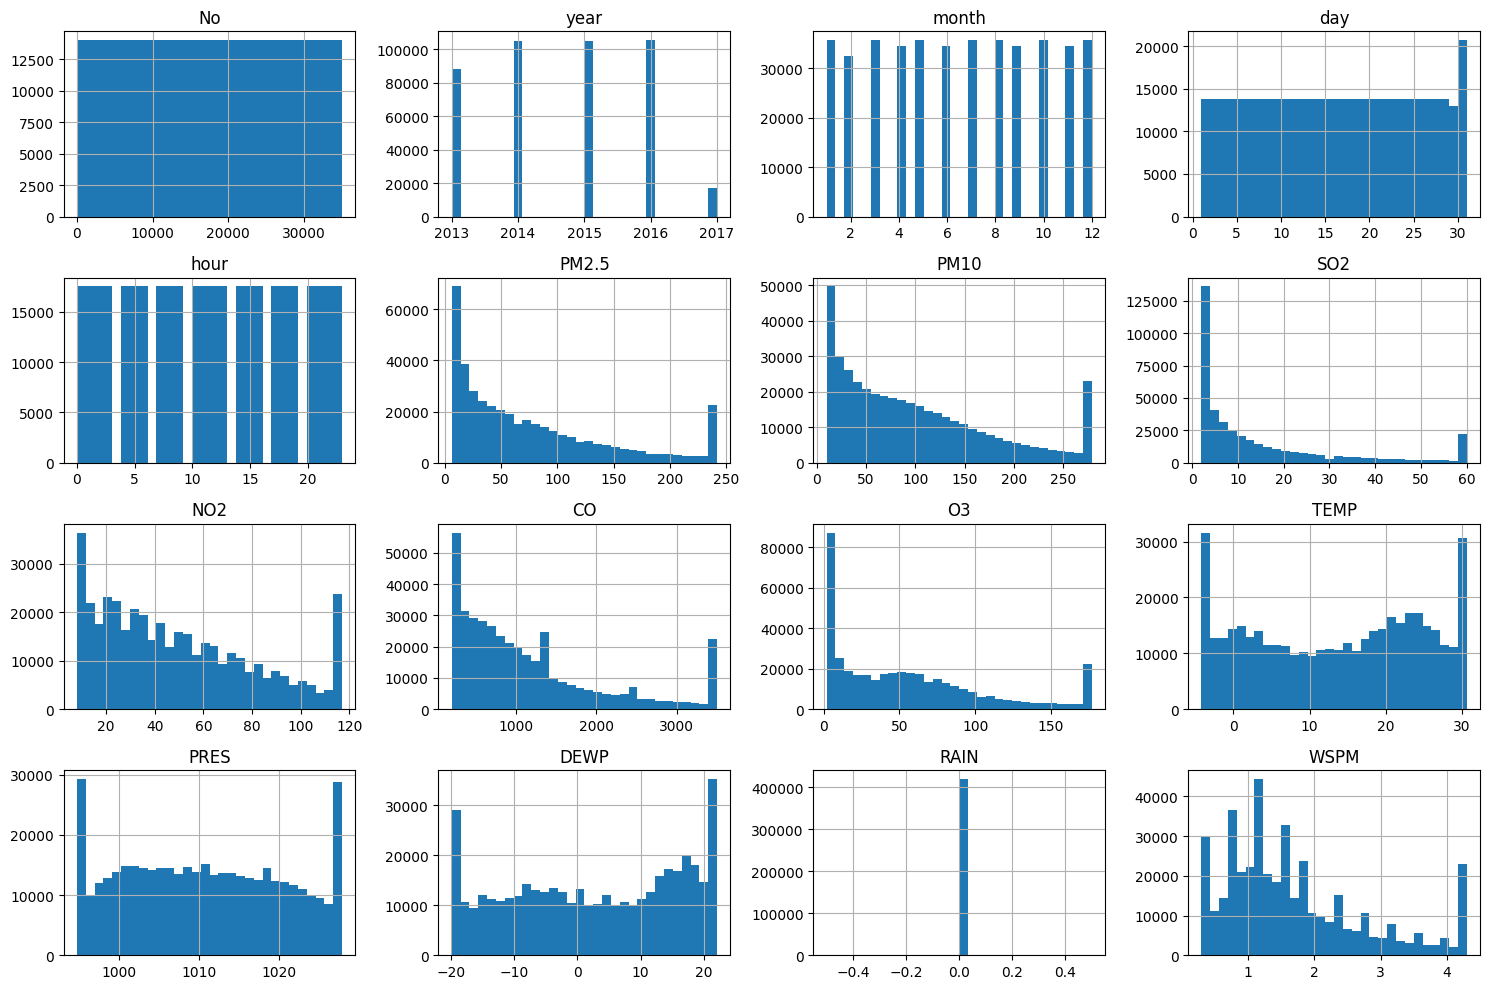

In [68]:
# Visualisasi histogram untuk setiap kolom
combined_data.hist(bins=30, figsize=(15, 10))
plt.tight_layout()
plt.show()

##### - Boxplot

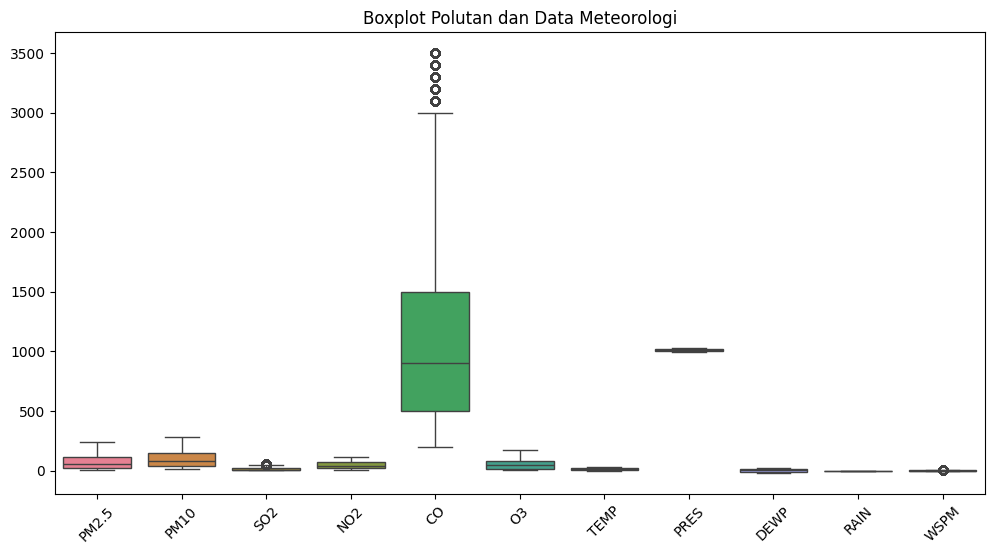

In [69]:
# Boxplot untuk kolom polutan dan data meteorologi
plt.figure(figsize=(12, 6))
sns.boxplot(data=combined_data[['PM2.5', 'PM10', 'SO2', 'NO2',
            'CO', 'O3', 'TEMP', 'PRES', 'DEWP', 'RAIN', 'WSPM']])
plt.xticks(rotation=45)
plt.title('Boxplot Polutan dan Data Meteorologi')
plt.show()

#### Analisi Korelasi

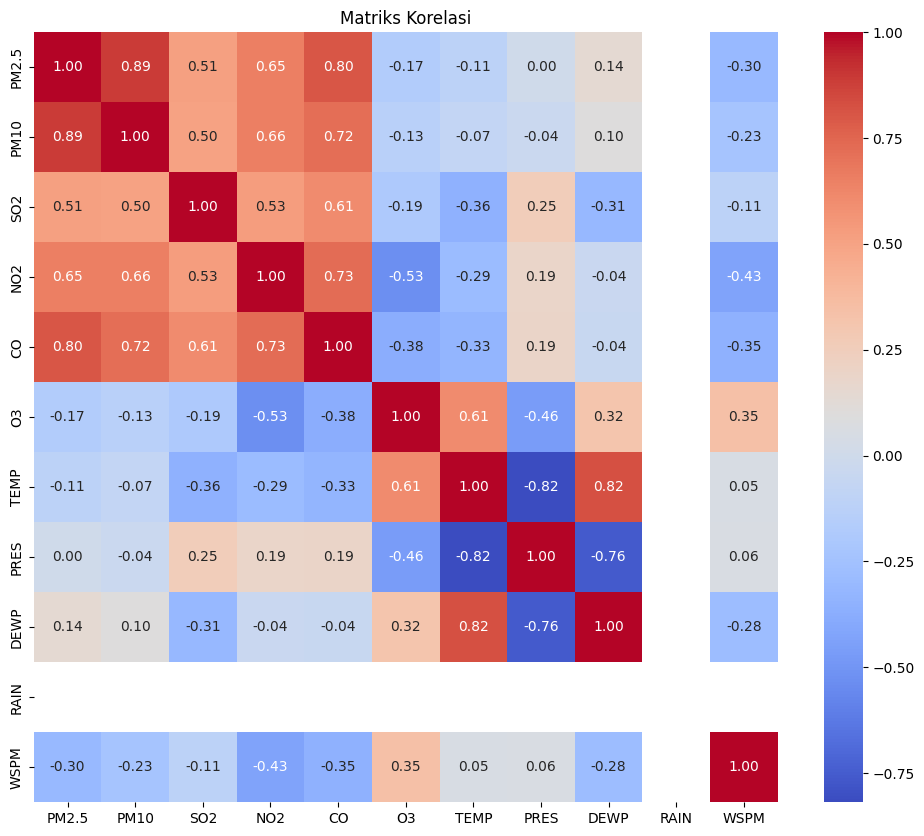

In [70]:
# Visualisasi matriks korelasi
columns_to_use = ['PM2.5', 'PM10', 'SO2', 'NO2', 'CO',
                  'O3', 'TEMP', 'PRES', 'DEWP', 'RAIN', 'WSPM']
correlation_matrix = combined_data[columns_to_use].corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Matriks Korelasi')
plt.show()

#### Analisis Tren Waktu 

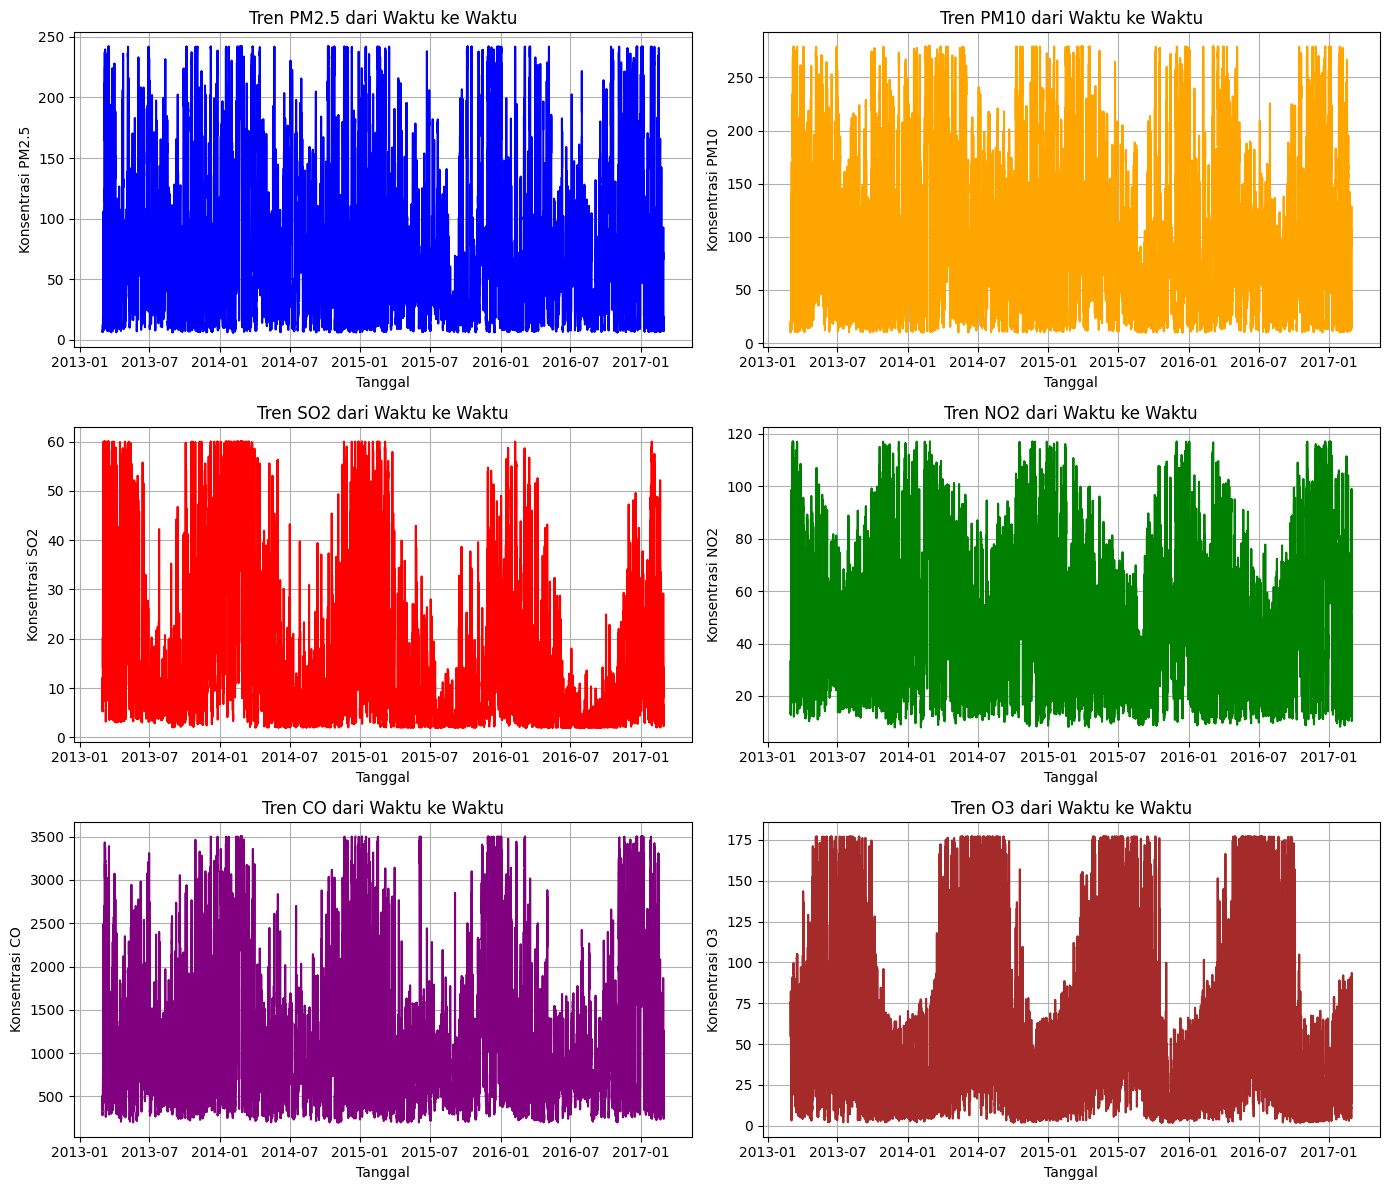

In [71]:
# Analisis tren kualitas udara berdasarkan waktu
combined_data['date'] = pd.to_datetime(combined_data[['year', 'month', 'day', 'hour']])
trend_pm2_5 = combined_data.groupby('date')['PM2.5'].mean().reset_index()
trend_pm10 = combined_data.groupby('date')['PM10'].mean().reset_index()
trend_so2 = combined_data.groupby('date')['SO2'].mean().reset_index()
trend_no2 = combined_data.groupby('date')['NO2'].mean().reset_index()
trend_co = combined_data.groupby('date')['CO'].mean().reset_index()
trend_o3 = combined_data.groupby('date')['O3'].mean().reset_index()

plt.figure(figsize=(14, 12))

# Plot untuk PM2.5
plt.subplot(3, 2, 1)
plt.plot(trend_pm2_5['date'], trend_pm2_5['PM2.5'], color='blue')
plt.title('Tren PM2.5 dari Waktu ke Waktu')
plt.xlabel('Tanggal')
plt.ylabel('Konsentrasi PM2.5')
plt.grid()

# Plot untuk PM10
plt.subplot(3, 2, 2)
plt.plot(trend_pm10['date'], trend_pm10['PM10'], color='orange')
plt.title('Tren PM10 dari Waktu ke Waktu')
plt.xlabel('Tanggal')
plt.ylabel('Konsentrasi PM10')
plt.grid()

# Plot untuk SO2
plt.subplot(3, 2, 3)
plt.plot(trend_so2['date'], trend_so2['SO2'], color='red')
plt.title('Tren SO2 dari Waktu ke Waktu')
plt.xlabel('Tanggal')
plt.ylabel('Konsentrasi SO2')
plt.grid()

# Plot untuk NO2
plt.subplot(3, 2, 4)
plt.plot(trend_no2['date'], trend_no2['NO2'], color='green')
plt.title('Tren NO2 dari Waktu ke Waktu')
plt.xlabel('Tanggal')
plt.ylabel('Konsentrasi NO2')
plt.grid()

# Plot untuk CO
plt.subplot(3, 2, 5)
plt.plot(trend_co['date'], trend_co['CO'], color='purple')
plt.title('Tren CO dari Waktu ke Waktu')
plt.xlabel('Tanggal')
plt.ylabel('Konsentrasi CO')
plt.grid()

# Plot untuk O3
plt.subplot(3, 2, 6)
plt.plot(trend_o3['date'], trend_o3['O3'], color='brown')
plt.title('Tren O3 dari Waktu ke Waktu')
plt.xlabel('Tanggal')
plt.ylabel('Konsentrasi O3')
plt.grid()

plt.tight_layout()
plt.show()


#### Segmentasi Berdasarkan Lokasi

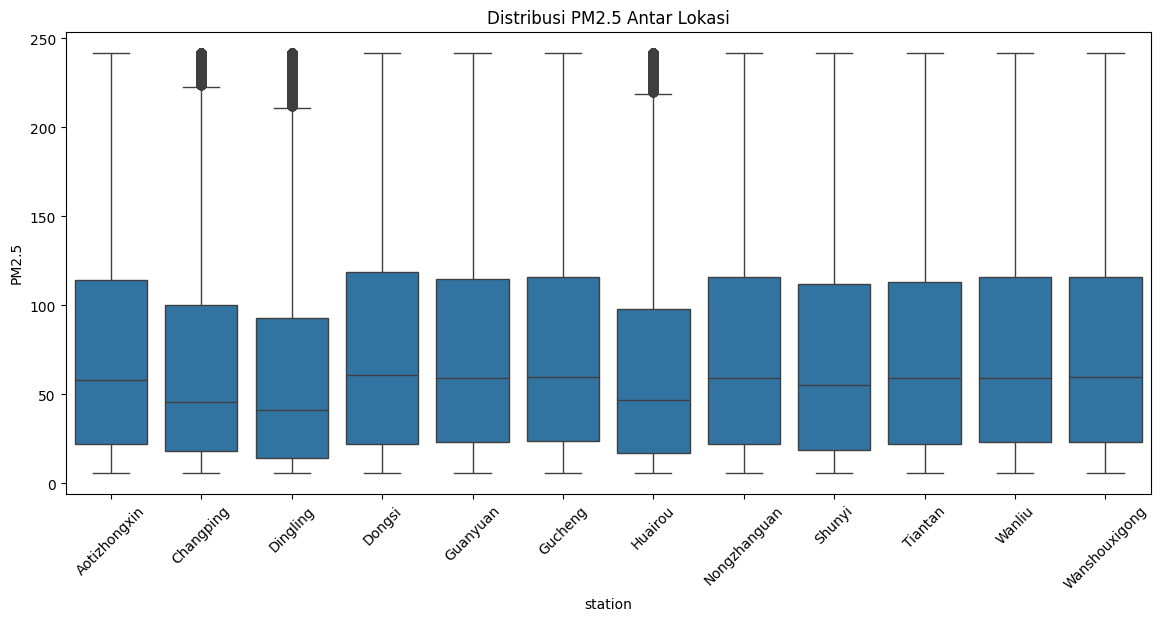

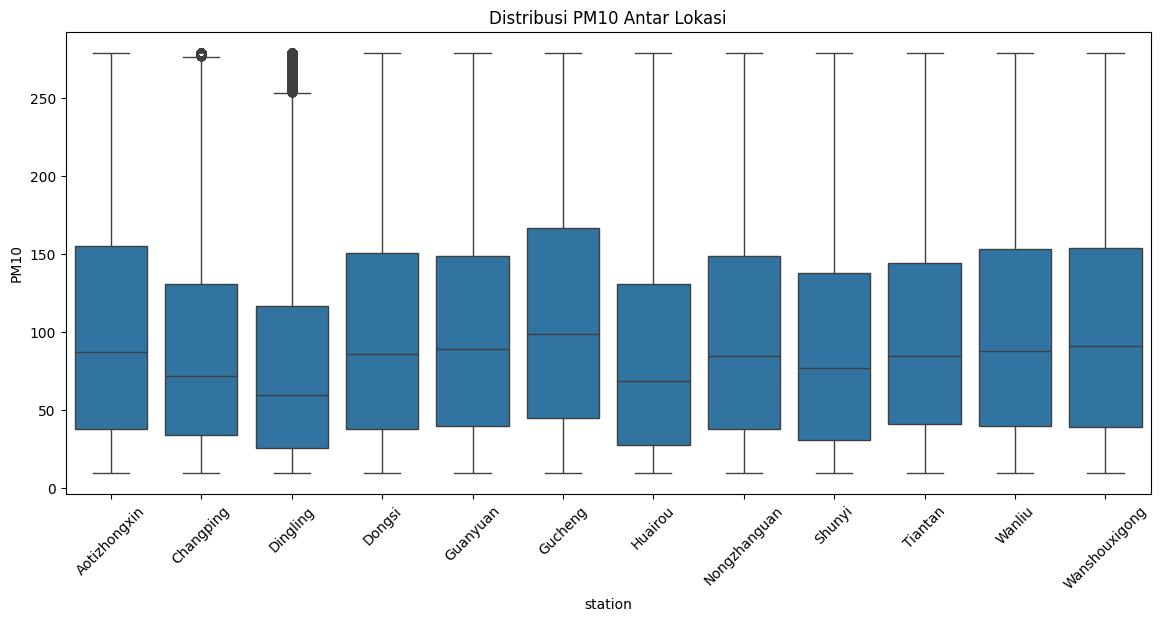

In [72]:
# Visualisasi perbandingan kualitas udara antar lokasi
plt.figure(figsize=(14, 6))
sns.boxplot(data=combined_data, x='station', y='PM2.5')
plt.title('Distribusi PM2.5 Antar Lokasi')
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(14, 6))
sns.boxplot(data=combined_data, x='station', y='PM10')
plt.title('Distribusi PM10 Antar Lokasi')
plt.xticks(rotation=45)
plt.show()

#### Kategorisasi Data

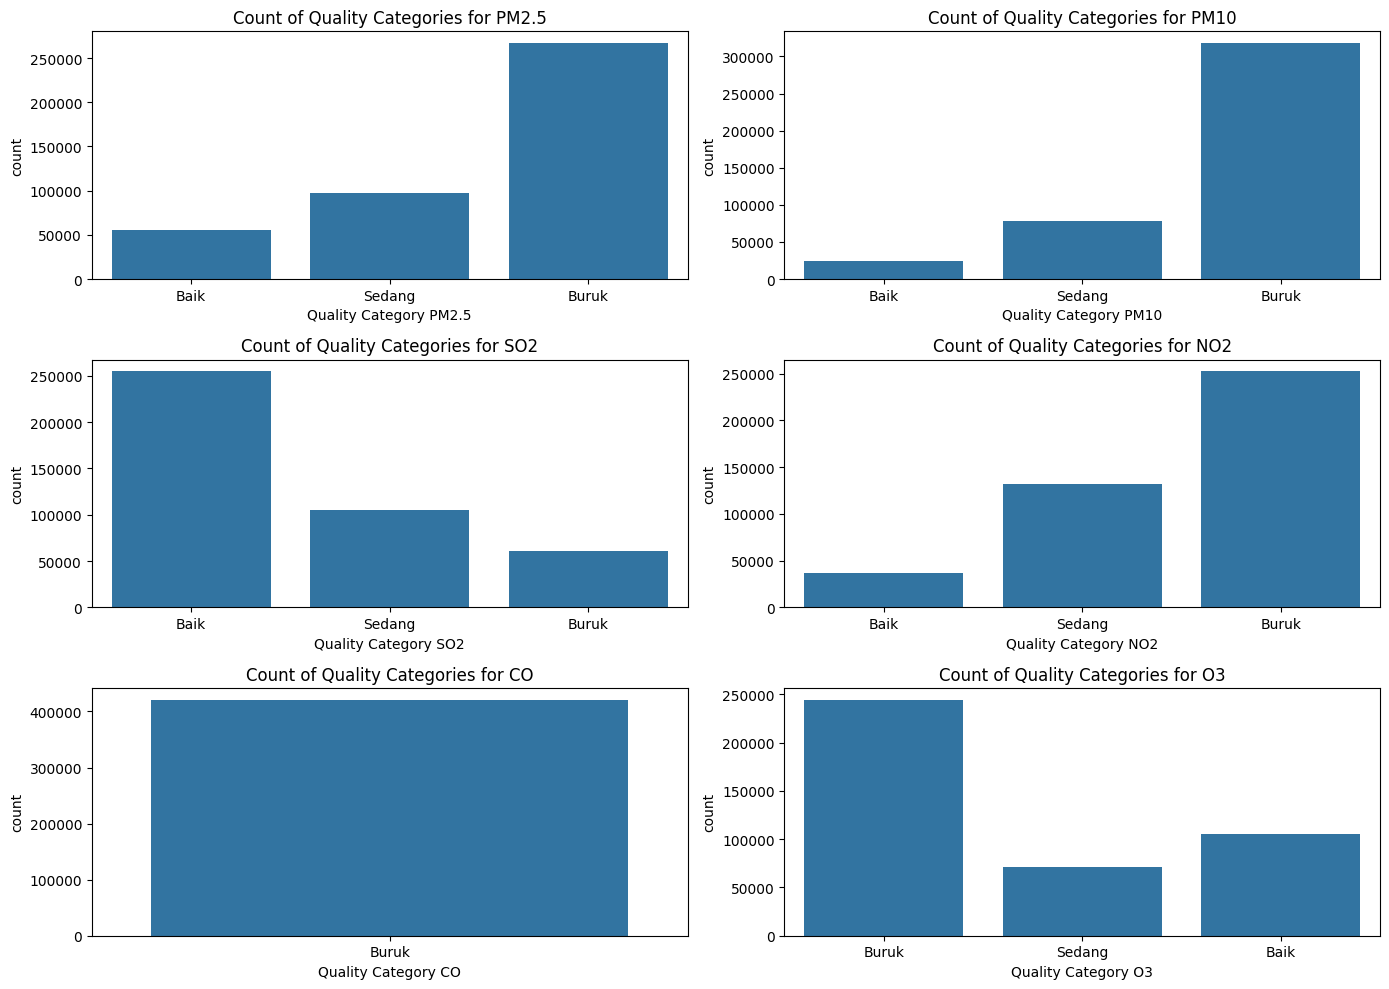

In [73]:
# Fungsi untuk mengkategorikan kualitas berdasarkan nilai
def categorize_quality(column_name, thresholds):
    return combined_data[column_name].apply(
        lambda x: thresholds[0] if x < 12 else (thresholds[1] if x <= 35.4 else thresholds[2])
    )

# Kategori untuk masing-masing kolom
quality_categories = {
    'PM2.5': ['Baik', 'Sedang', 'Buruk'],
    'PM10': ['Baik', 'Sedang', 'Buruk'],
    'SO2': ['Baik', 'Sedang', 'Buruk'],
    'NO2': ['Baik', 'Sedang', 'Buruk'],
    'CO': ['Baik', 'Sedang', 'Buruk'],
    'O3': ['Baik', 'Sedang', 'Buruk']
}

# Kategorikan setiap kolom dan buat countplot
plt.figure(figsize=(14, 10))

# Kategorikan PM2.5
combined_data['Quality Category PM2.5'] = categorize_quality('PM2.5', quality_categories['PM2.5'])
plt.subplot(3, 2, 1)
sns.countplot(data=combined_data, x='Quality Category PM2.5')
plt.title('Count of Quality Categories for PM2.5')

# Kategorikan PM10
combined_data['Quality Category PM10'] = categorize_quality('PM10', quality_categories['PM10'])
plt.subplot(3, 2, 2)
sns.countplot(data=combined_data, x='Quality Category PM10')
plt.title('Count of Quality Categories for PM10')

# Kategorikan SO2
combined_data['Quality Category SO2'] = categorize_quality('SO2', quality_categories['SO2'])
plt.subplot(3, 2, 3)
sns.countplot(data=combined_data, x='Quality Category SO2')
plt.title('Count of Quality Categories for SO2')

# Kategorikan NO2
combined_data['Quality Category NO2'] = categorize_quality('NO2', quality_categories['NO2'])
plt.subplot(3, 2, 4)
sns.countplot(data=combined_data, x='Quality Category NO2')
plt.title('Count of Quality Categories for NO2')

# Kategorikan CO
combined_data['Quality Category CO'] = categorize_quality('CO', quality_categories['CO'])
plt.subplot(3, 2, 5)
sns.countplot(data=combined_data, x='Quality Category CO')
plt.title('Count of Quality Categories for CO')

# Kategorikan O3
combined_data['Quality Category O3'] = categorize_quality('O3', quality_categories['O3'])
plt.subplot(3, 2, 6)
sns.countplot(data=combined_data, x='Quality Category O3')
plt.title('Count of Quality Categories for O3')

plt.tight_layout()
plt.show()

## Visualization & Explanatory Analysis

### Pertanyaan 1: 
Bagaimana tren kualitas udara (PM2.5 dan PM10) di berbagai lokasi dari tahun 2013 hingga 2017? <br>
Tren Kualitas Udara (PM2.5 dan PM10) di Berbagai Lokasi (2013-2017)

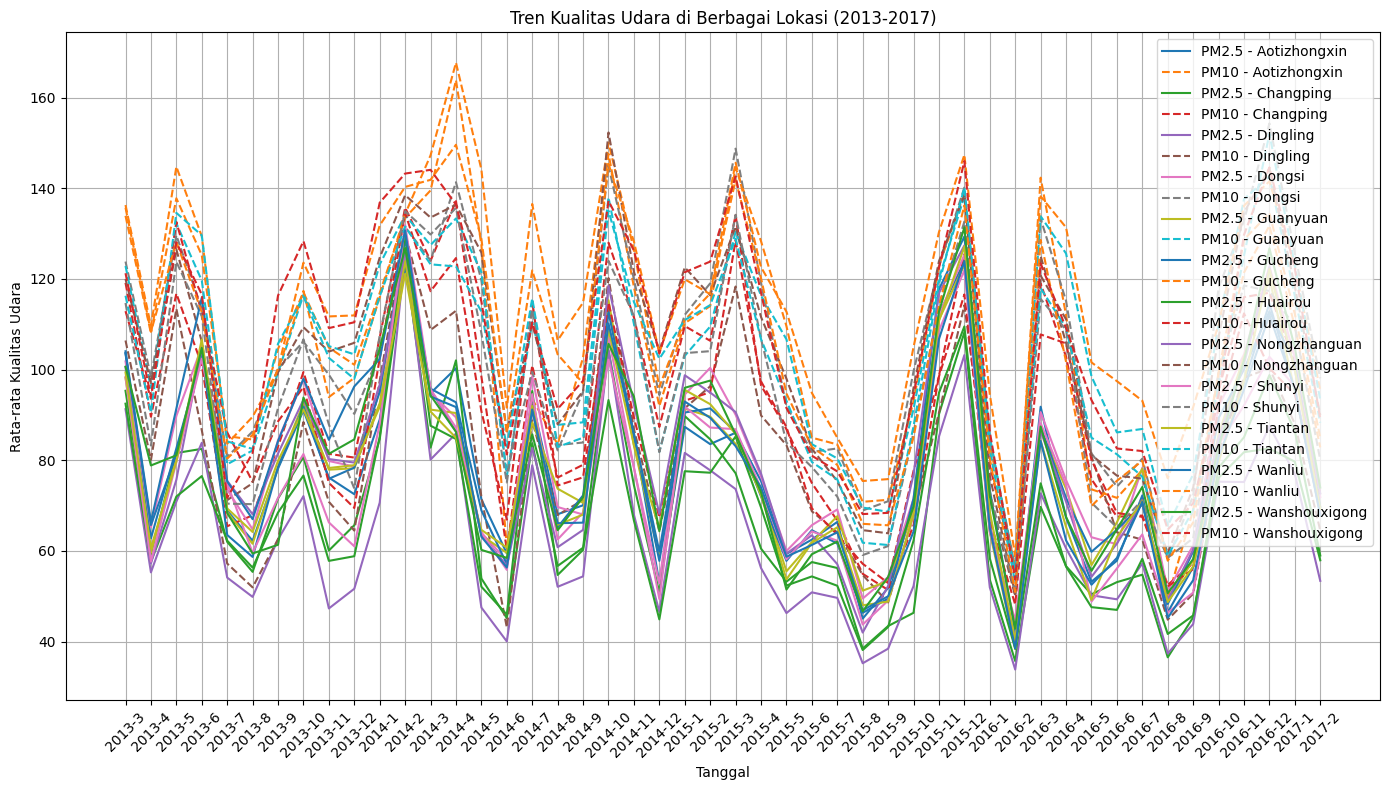

In [74]:
# Mengelompokkan data berdasarkan tahun, bulan, dan stasiun untuk menghitung rata-rata
trend_pm = combined_data.groupby(['year', 'month', 'station'])[['PM2.5', 'PM10']].mean().reset_index()

# Buat grafik tren untuk PM2.5 dan PM10
plt.figure(figsize=(14, 8))
for station in trend_pm['station'].unique():
    station_data = trend_pm[trend_pm['station'] == station]
    plt.plot(station_data['year'].astype(str) + '-' + station_data['month'].astype(str), 
             station_data['PM2.5'], label=f'PM2.5 - {station}')
    plt.plot(station_data['year'].astype(str) + '-' + station_data['month'].astype(str), 
             station_data['PM10'], label=f'PM10 - {station}', linestyle='--')

plt.title('Tren Kualitas Udara di Berbagai Lokasi (2013-2017)')
plt.xlabel('Tanggal')
plt.ylabel('Rata-rata Kualitas Udara')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

##### Grafik Fluktuasi Konsentrasi Partikulat Matter (PM2.5 dan PM10)

Grafik ini menunjukkan perubahan konsentrasi PM2.5 dan PM10 di berbagai lokasi dari tahun 2013 hingga 2017. Setiap garis mewakili lokasi dan jenis partikel tertentu (PM2.5 atau PM10).

- **PM2.5 dan PM10**: Partikel kecil di udara, di mana PM2.5 lebih kecil dari PM10 dan lebih berbahaya karena dapat menembus paru-paru.
- **Sumbu-X**: Menampilkan waktu dari tahun 2013 hingga 2017.
- **Sumbu-Y**: Menunjukkan konsentrasi partikel dalam mikrogram per meter kubik (μg/m³). Semakin tinggi angkanya, semakin tinggi tingkat polusi.

##### Tren Utama

1. **Fluktuasi Musiman**: Ada pola musiman yang jelas di sebagian besar lokasi. Konsentrasi partikel meningkat di musim dingin atau kemarau dan menurun saat musim hujan, kemungkinan dipengaruhi oleh kondisi cuaca seperti kelembapan dan angin.
2. **Variasi Antar Lokasi**: Setiap lokasi memiliki pola polusi yang berbeda, dengan beberapa lokasi menunjukkan fluktuasi lebih besar, yang mungkin terkait aktivitas industri, lalu lintas, atau geografis.
3. **Peningkatan Konsentrasi**: Di beberapa lokasi, terutama untuk PM2.5, ada tren peningkatan dari tahun ke tahun, mengindikasikan aktivitas yang menghasilkan partikel halus semakin meningkat.

##### Insight dan Kesimpulan

1. **Kualitas Udara Masih Bermasalah**: Fluktuasi yang tinggi dan tren peningkatan di beberapa lokasi menunjukkan kualitas udara yang perlu mendapat perhatian serius.
2. **Pentingnya Pemantauan Berkelanjutan**: Pemantauan rutin penting untuk mengidentifikasi sumber pencemaran dan mengevaluasi efektivitas kebijakan pengendalian.
3. **Dibutuhkan Strategi Pengendalian Terpadu**: Perbaikan kualitas udara memerlukan strategi pengendalian yang melibatkan sektor industri, transportasi, dan energi, disesuaikan dengan kondisi setiap lokasi.


### Pertanyaan 2: <br> 
Bagaimana tren kualitas udara (PM2.5 dan PM10) di berbagai lokasi dari tahun 2013 hingga 2017? <br>
Pengaruh Faktor Meteorologi terhadap Konsentrasi Polutan

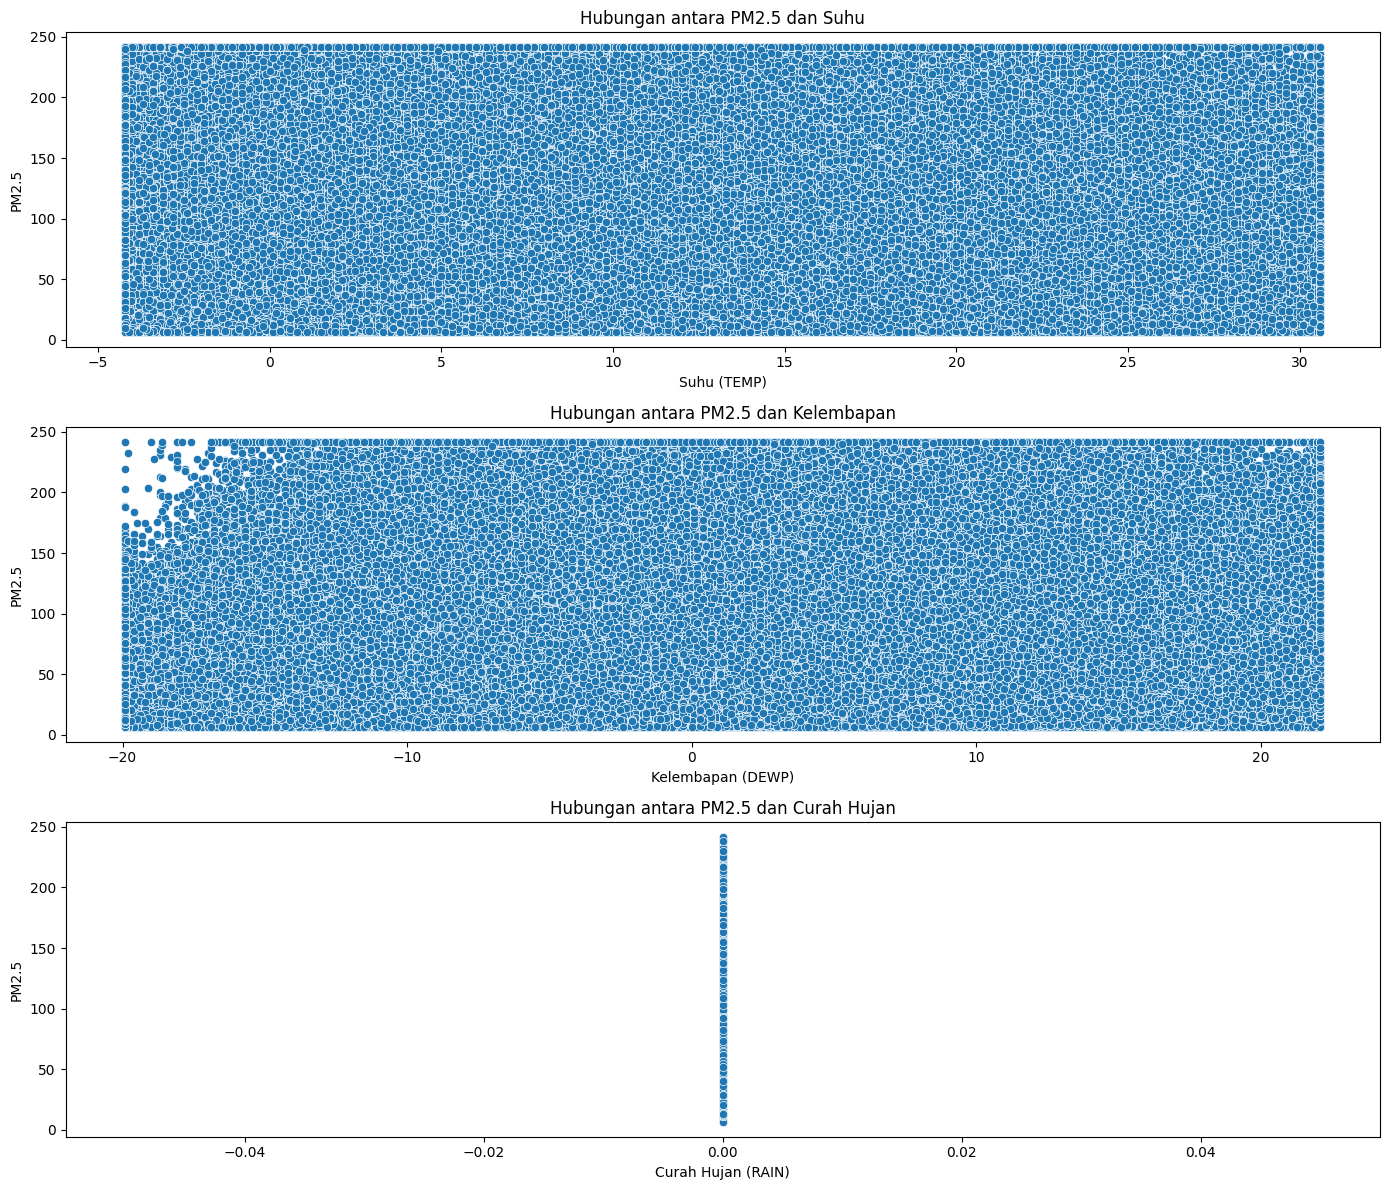

In [75]:
# Visualisasi hubungan antara PM2.5 dan faktor meteorologi
plt.figure(figsize=(14, 12))

# Hubungan PM2.5 dan Suhu
plt.subplot(3, 1, 1)
sns.scatterplot(data=combined_data, x='TEMP', y='PM2.5')
plt.title('Hubungan antara PM2.5 dan Suhu')
plt.xlabel('Suhu (TEMP)')
plt.ylabel('PM2.5')

# Hubungan PM2.5 dan Kelembapan
plt.subplot(3, 1, 2)
sns.scatterplot(data=combined_data, x='DEWP', y='PM2.5')
plt.title('Hubungan antara PM2.5 dan Kelembapan')
plt.xlabel('Kelembapan (DEWP)')
plt.ylabel('PM2.5')

# Hubungan PM2.5 dan Curah Hujan
plt.subplot(3, 1, 3)
sns.scatterplot(data=combined_data, x='RAIN', y='PM2.5')
plt.title('Hubungan antara PM2.5 dan Curah Hujan')
plt.xlabel('Curah Hujan (RAIN)')
plt.ylabel('PM2.5')

plt.tight_layout()
plt.show()


### Hubungan Antara PM2.5 dan Faktor Meteorologi

Grafik di atas menunjukkan hubungan antara konsentrasi partikel halus PM2.5 dengan tiga faktor meteorologi utama: suhu, kelembapan, dan curah hujan. Setiap titik mewakili satu pengamatan, dengan sumbu x menunjukkan faktor meteorologi, dan sumbu y menunjukkan konsentrasi PM2.5.

#### Interpretasi Grafik

##### 1. Hubungan PM2.5 dan Suhu
- **Pola**: Titik data tersebar merata di sepanjang sumbu suhu tanpa pola yang jelas, menunjukkan tidak ada korelasi kuat antara suhu dan PM2.5.
- **Interpretasi**: Suhu mungkin bukan faktor utama yang memengaruhi konsentrasi PM2.5 di wilayah ini. Faktor lain, seperti aktivitas manusia, kondisi angin, dan topografi, kemungkinan lebih berpengaruh.

##### 2. Hubungan PM2.5 dan Kelembapan
- **Pola**: Titik data terkonsentrasi pada rentang kelembapan tertentu, dengan variasi konsentrasi PM2.5 yang tidak menunjukkan pola peningkatan atau penurunan yang jelas.
- **Interpretasi**: Kelembapan mungkin mempengaruhi PM2.5, tetapi pengaruhnya tidak konsisten. Faktor lain, seperti sifat partikel dan sumber emisi, juga perlu dipertimbangkan.

##### 3. Hubungan PM2.5 dan Curah Hujan
- **Pola**: Sebagian besar titik data berada pada nilai curah hujan yang sangat rendah, menunjukkan pengamatan sebagian besar dilakukan dalam kondisi kering.
- **Interpretasi**: Data terbatas pada kondisi kering membuat sulit menyimpulkan hubungan curah hujan dengan PM2.5. Namun, secara umum, hujan dapat membersihkan udara dengan menghilangkan partikel dari atmosfer.

### Kesimpulan dan Insight

1. **Hubungan Kompleks**: Hubungan antara PM2.5 dan faktor meteorologi bersifat kompleks dan tidak linear. Faktor lain, seperti emisi, angin, dan topografi, memainkan peran penting.
2. **Data Terbatas**: Data yang tersedia kurang representatif, terutama dalam kondisi hujan, sehingga sulit menarik kesimpulan yang lebih menyeluruh.
3. **Perlunya Analisis Lanjutan**: Analisis lebih mendalam diperlukan untuk memahami interaksi berbagai faktor lain, seperti sumber emisi dan karakteristik partikel, dalam memengaruhi konsentrasi PM2.5.


### Pertanyaan 3:
Apakah ada perbedaan signifikan dalam kualitas udara antara lokasi yang berbeda pada waktu tertentu? <br>
Perbedaan Kualitas Udara antara Lokasi yang Berbeda

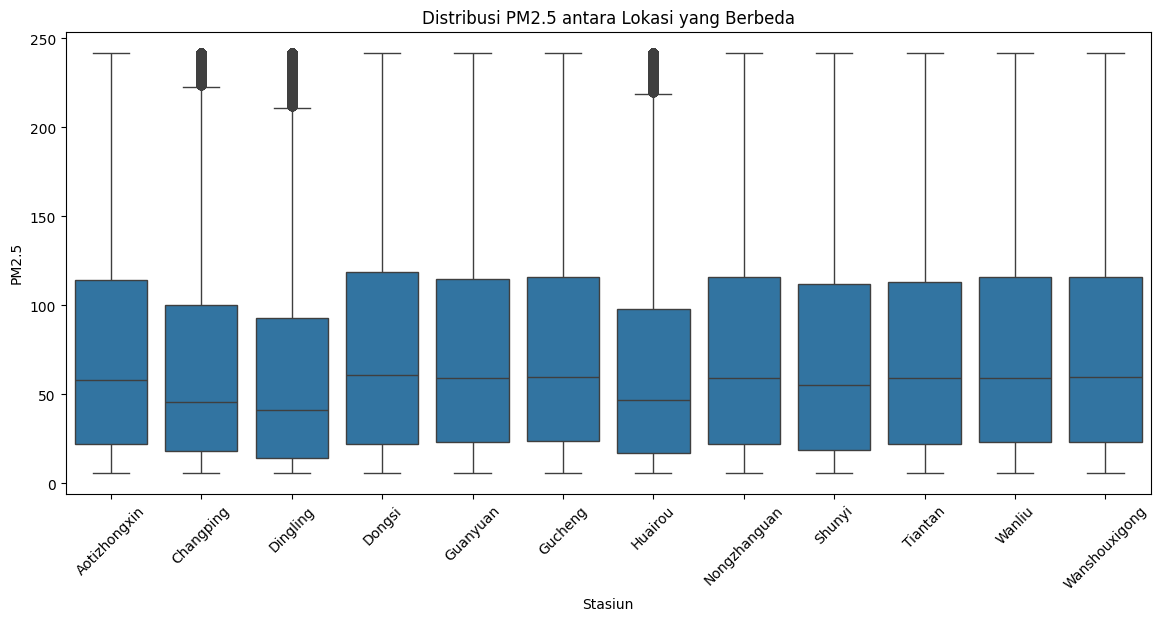

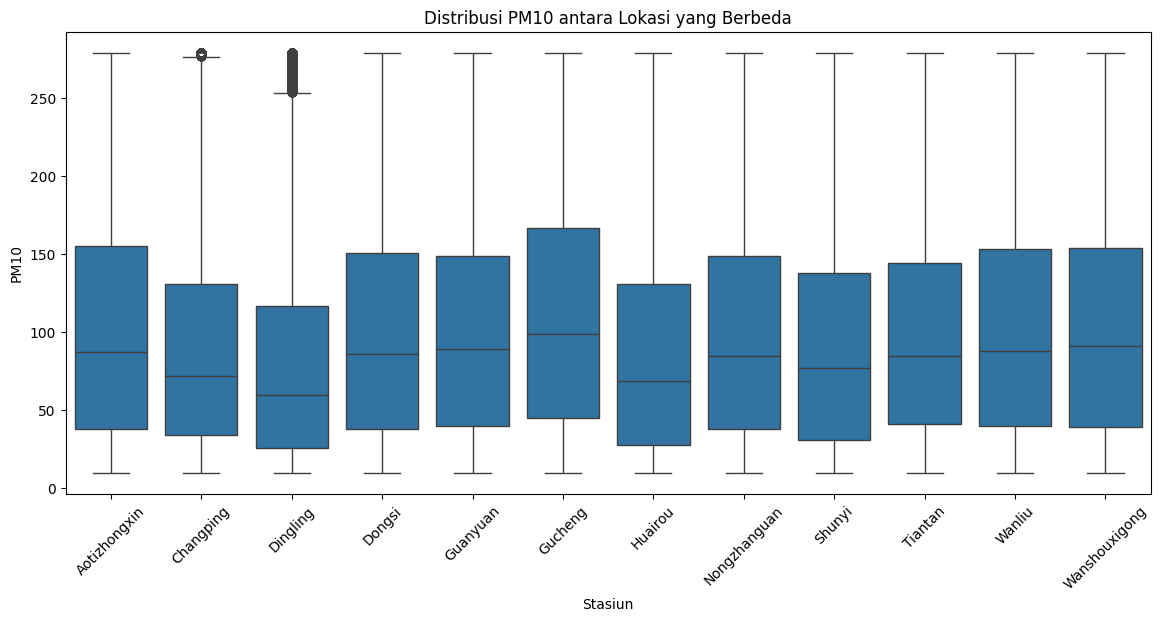

In [76]:
# Boxplot untuk perbandingan kualitas udara antara lokasi
plt.figure(figsize=(14, 6))
sns.boxplot(data=combined_data, x='station', y='PM2.5')
plt.title('Distribusi PM2.5 antara Lokasi yang Berbeda')
plt.xlabel('Stasiun')
plt.ylabel('PM2.5')
plt.xticks(rotation=45)
plt.show()

# Boxplot untuk PM10
plt.figure(figsize=(14, 6))
sns.boxplot(data=combined_data, x='station', y='PM10')
plt.title('Distribusi PM10 antara Lokasi yang Berbeda')
plt.xlabel('Stasiun')
plt.ylabel('PM10')
plt.xticks(rotation=45)
plt.show()


### Analisis Grafik Distribusi PM2.5 dan PM10

Dari grafik, kita dapat mengamati beberapa hal penting:

1. **Perbedaan Kualitas Udara**: Terdapat perbedaan signifikan dalam konsentrasi PM2.5 dan PM10 di berbagai lokasi, yang ditunjukkan oleh variasi tinggi kotak dan posisi median.
2. **Variabilitas Data**: Beberapa lokasi menunjukkan rentang variasi konsentrasi yang lebih lebar, terlihat dari perbedaan panjang kotak dan whisker pada setiap lokasi.
3. **Outlier**: Terdapat beberapa lokasi dengan nilai outlier, menunjukkan konsentrasi PM2.5 dan PM10 yang jauh lebih tinggi atau lebih rendah dari mayoritas data.

### Insight dan Kesimpulan

1. **Faktor Lokal yang Mempengaruhi**: Perbedaan kualitas udara antar lokasi kemungkinan disebabkan oleh faktor lokal, seperti aktivitas industri, kepadatan penduduk, kondisi geografis, dan pola angin.
2. **Sumber Pencemaran**: Lokasi dengan konsentrasi PM2.5 dan PM10 yang tinggi mungkin memiliki sumber pencemaran yang lebih besar atau lebih banyak dibandingkan lokasi lainnya.
3. **Kebijakan Pengendalian**: Hasil ini dapat dijadikan acuan dalam merumuskan kebijakan pengendalian pencemaran udara yang lebih efektif dan tertarget.
4. **Pemantauan Berkala**: Pemantauan kualitas udara secara rutin sangat penting untuk mengidentifikasi masalah dan menilai efektivitas kebijakan pengendalian yang diterapkan

## Analisis Lanjutan (Opsional)

#### Geospatial Analysis
Menggunakan GeoPandas atau folium untuk membuat peta interaktif yang menampilkan distribusi polutan berdasarkan lokasi.

In [77]:
# Visualisasi peta stasiun dengan Folium
station_coords = {
    'Aotizhongxin': {'lat': 39.978, 'lon': 116.407},
    'Changping': {'lat': 40.217, 'lon': 116.235},
    'Dingling': {'lat': 40.292, 'lon': 116.227},
    'Dongsi': {'lat': 39.93, 'lon': 116.42},
    'Guanyuan': {'lat': 39.929, 'lon': 116.344},
    'Gucheng': {'lat': 39.914, 'lon': 116.184},
    'Huairou': {'lat': 40.375, 'lon': 116.628},
    'Nongzhanguan': {'lat': 39.934, 'lon': 116.455},
    'Shunyi': {'lat': 40.127, 'lon': 116.655},
    'Tiantan': {'lat': 39.886, 'lon': 116.414},
    'Wanliu': {'lat': 39.997, 'lon': 116.304},
    'Wanshouxigong': {'lat': 39.878, 'lon': 116.339},
}

m = folium.Map(location=[39.9042, 116.4074], zoom_start=10)
for station, coords in station_coords.items():
    avg_pm25 = combined_data[combined_data['station']
                             == station]['PM2.5'].mean()
    if avg_pm25 < 50:
        color = 'green'
    elif avg_pm25 < 100:
        color = 'yellow'
    elif avg_pm25 < 150:
        color = 'orange'
    else:
        color = 'red'
    folium.Marker([coords['lat'], coords['lon']], popup=f"{station}: {
                  avg_pm25:.2f} µg/m³", icon=folium.Icon(color=color)).add_to(m)

# Simpan peta
m.save('dashboard/air_quality_map.html')
print("Peta berhasil dibuat dan disimpan ke air_quality_map.html")
m


C:\Users\Mr Tuesday\AppData\Local\Temp\ipykernel_9736\57283621.py:30: UserWarning: color argument of Icon should be one of: {'gray', 'darkred', 'lightgray', 'purple', 'green', 'beige', 'blue', 'darkgreen', 'lightred', 'pink', 'cadetblue', 'darkblue', 'orange', 'black', 'darkpurple', 'white', 'red', 'lightblue', 'lightgreen'}.
  avg_pm25:.2f} µg/m³", icon=folium.Icon(color=color)).add_to(m)


Peta berhasil dibuat dan disimpan ke air_quality_map.html


## Conclusion

#### Pertanyaan 1:
Kualitas udara di berbagai lokasi mengalami fluktuasi signifikan dari waktu ke waktu. Pola musiman terlihat jelas, dengan peningkatan konsentrasi polutan pada musim tertentu, seperti musim kemarau. Beberapa lokasi menunjukkan tren peningkatan konsentrasi polutan dari tahun ke tahun, yang mungkin disebabkan oleh peningkatan aktivitas yang menghasilkan polusi.

#### Pertanyaan 2:
Hubungan antara konsentrasi PM2.5 dan PM10 dengan faktor meteorologi seperti suhu, kelembapan, dan curah hujan tidak bersifat linear atau sederhana. Faktor meteorologi hanya satu dari banyak faktor yang memengaruhi kualitas udara, dengan emisi dari aktivitas manusia juga memainkan peran penting. Terbatasnya data pada kondisi tertentu (seperti cuaca kering) membuat sulit untuk menyimpulkan hubungan yang kuat antara variabel-variabel ini.

#### Pertanyaan 3:
Kualitas udara bervariasi secara signifikan antar lokasi, dipengaruhi oleh faktor-faktor lokal seperti aktivitas industri, kepadatan penduduk, dan kondisi geografis. Adanya nilai outlier mengindikasikan adanya kejadian khusus yang menyebabkan lonjakan konsentrasi polutan di beberapa lokasi.